In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import hvplot.pandas

ModuleNotFoundError: No module named 'hvplot'

In [4]:
from os import listdir
from os.path import isfile

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
dir = "../Resources/"

In [7]:
# Read all the files from the resources and put them in a list
all_files = [x for x in listdir(dir) if (".xlsx" in x or ".csv" in x)]
all_files

['corn.xlsx',
 'feeder_cattle.xlsx',
 'live_cattle.xlsx',
 'soybean_meal.xlsx',
 'lean_hogs.xlsx',
 'soybeans.xlsx']

In [8]:
all_df = pd.DataFrame()
for x in all_files:
    a = x.replace(".xlsx", "")
    df = pd.read_excel(dir+x)
    df["name"] = a
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")
    df = df.sort_index()
    df = df.dropna()
    df = df[df['Volume'] != 0.0]
    df.drop(['Volume'], axis=1, inplace=True)
    if a == "corn":
        corn = df
        all_df["corn"] = corn["Price"]
    elif a == "live_cattle":
        live_cattle = df
        all_df["live_cattle"] = live_cattle["Price"]
    elif a == "feeder_cattle":
        feeder_cattle = df
        all_df["feeder_cattle"] = feeder_cattle["Price"]
    elif a == "soybean_meal":
        soybean = df
        all_df["soybean"] = soybean["Price"]
    elif a == "lean_hogs":
        hog = df
        all_df["hog"] = hog["Price"]

In [9]:
all_df['hog_delta_5'] = all_df["hog"].shift(105)
all_df['corn_delta_5'] = all_df["corn"].shift(105)
all_df['soybean_delta_5'] = all_df["soybean"].shift(105)
all_df = all_df.dropna()
# Crush Margin = 2 x CME lean hog futures price (5 months
# from placement) – 0.5 x CME lean hog futures price (5
# months from placement) – 10 x CME corn futures price (at
# placement) – 0.075 x CME soybean meal futures price (at
# placement)
# GFM t= 2.05 * LH t - WP t-5-(10 * C t-5)-(0.075 * SM t-5)
all_df["GFM"] = (2.05*all_df["hog"]) - (all_df['hog_delta_5']*0.5) - (10 * all_df['corn_delta_5']) - (0.075 * all_df['soybean_delta_5'])
all_df = all_df.drop(columns=['feeder_cattle', 'live_cattle', 'hog_delta_5', 'corn_delta_5', 'soybean_delta_5'])
all_df.head(10)

,corn,soybean,hog,GFM
Date,,,,
2001-06-04,2.1500,151.9,52.075,43.60625
2001-06-05,2.1425,152.2,51.575,42.77375
2001-06-06,2.1725,154.1,51.425,42.60625
2001-06-07,2.1700,153.8,51.600,42.64500
2001-06-08,2.1550,155.7,52.675,45.30625
2001-06-11,2.1725,156.8,53.375,46.54625
2001-06-12,2.1575,158.6,53.525,46.59875
2001-06-13,2.1525,157.7,53.600,46.86250
2001-06-14,2.1350,156.9,52.925,46.18375


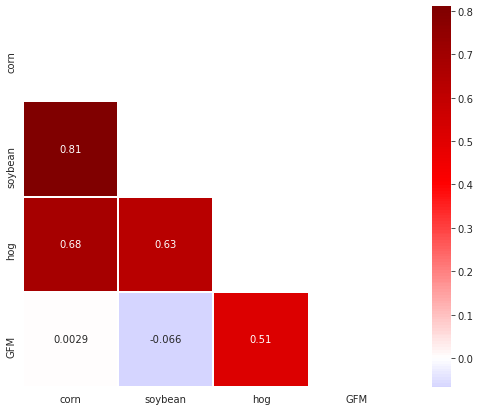

In [10]:
all_df = all_df.dropna()
corrM = all_df.corr()

mask = np.zeros_like(corrM)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10,7))
    ax = sns.heatmap(corrM, mask=mask, center=0, annot=True, square=True, linewidths=1, cmap="seismic")

In [11]:
all_df.hvplot.line(xlabel="Time", ylabel="Price")

AttributeError: 'DataFrame' object has no attribute 'hvplot'

In [ ]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
window_size = 10

feature_column = 3
target_column = 2
X, y = window_data(all_df, window_size, feature_column, target_column)

In [ ]:
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()

scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [12]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

NameError: name 'X_train' is not defined

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras import metrics
# from tensorflow.keras import layers
# from tensorflow.keras import activations

In [14]:
model = Sequential()
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (X_train.shape[1],1))
         )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model.add(Dropout(dropout_fraction))

model.add(Dense(1))
# model.add(Dense(12, input_dim=8, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.add(Activation('linear'))
# model.add(Activation('softmax')) 

NameError: name 'X_train' is not defined

In [ ]:
model.compile(optimizer="adam", loss="mean_squared_error")
# model.compile(loss="mean_squared_error", optimizer = 'rmsprop', metrics=['accuracy'])
# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mean_squared_error', 'accuracy'])

In [ ]:
model.summary()

In [15]:
epochs = 200
batch_size = 64
model.fit(X_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, verbose=1, validation_data=(X_train, y_train))

NameError: name 'X_train' is not defined

In [16]:
model.evaluate(X_test, y_test, verbose=0)

NameError: name 'X_test' is not defined

In [17]:
predicted = model.predict(X_test)

NameError: name 'X_test' is not defined

In [18]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

NameError: name 'scaler' is not defined

In [19]:
metric = metrics.Accuracy()
metric.update_state(real_prices,predicted_prices)
metric.result().numpy()

NameError: name 'real_prices' is not defined

In [20]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(real_prices, predicted_prices))

NameError: name 'real_prices' is not defined

In [21]:
hogs = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel(),
} ,index = all_df.index[-len(real_prices): ]) 
hogs.head()

NameError: name 'real_prices' is not defined

In [22]:
hogs.hvplot.line(xlabel="Date", ylabel="Price")

NameError: name 'hogs' is not defined